In [11]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.datasets import fetch_lfw_people
from skimage import data, transform
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [43]:
def convolution2D(f, I):
    mf = len(f)
    nf = len(f[0])
    mI = len(I)
    nI = len(I[0])
    pad = int(nf/2)
    im_conv = np.zeros((mI, nI))
    padded_I = np.pad(I, pad, 'constant', constant_values=(0))
    for x in range(mI):
        for y in range(nI):
            for i in range(mf):
                for j in range(nf):
                    im_conv[x][y] += f[i][j] * padded_I[x-i+mf-1][y-j+nf-1]
    return im_conv

def compute_histogram(magnitude, angle):
    [rows, cols] = magnitude.shape
    histogram = np.zeros(9)
    
    for i in range(rows):
        for j in range(cols):
            if int(angle[i][j]) < 0:
                idx1, idx2 = 8, 0
                value = (idx2*20 - angle[i][j])/20
                histogram[idx1] = histogram[idx1] + (magnitude[i][j]*(value))
                histogram[idx2] = histogram[idx2] + (magnitude[i][j]*(1-value))
            elif int(angle[i][j]) >= 160:
                idx1, idx2 = 0, 8
                value = (angle[i][j] - idx2*20)/20
                histogram[idx1] = histogram[idx1] + (magnitude[i][j]*(value))
                histogram[idx2] = histogram[idx2] + (magnitude[i][j]*(1-value))  
            else:
                idx1, idx2 = int(angle[i][j]/ 20), int(angle[i][j]/ 20 + 1)
                value = (idx2*20 - angle[i][j])/20
                histogram[idx1] = histogram[idx1] + (magnitude[i][j]*(value))
                histogram[idx2] = histogram[idx2] + (magnitude[i][j]*(1-value))
    return histogram

def compute_hog_features(histogram):
    hog_list = []
    [rows, cols,k] = histogram.shape
    for i in range(rows-1):
        for j in range(cols-1):
            slide_block = list()
            slide_block = slide_block + list(histogram[i][j]) + list(histogram[i][j+1]) + list(histogram[i+1][j]) + list(histogram[i+1][j+1])
            value = math.sqrt(sum(k ** 2 for k in slide_block))
            
            if value != 0:
                slide_block = [x/value for x in slide_block]
            hog_list.append(slide_block) 
    hog_features = np.array(hog_list).flatten()
    #hog_features = [colss for rowss in hog_list for colss in rowss]
    return hog_features
    
def get_hog_features(img):
    rows,cols = img.shape
    cell_size = 8
    sobel_filterx = np.array([[-1, 0, 1], 
                             [-2, 0, 2], 
                             [-1, 0, 1]]) 
    sobel_filtery = np.array([[1, 2, 1], 
                             [0, 0, 0], 
                             [-1, -2, -1]]) 
    gradient_x = convolution2D(sobel_filterx, img)
    gradient_y = convolution2D(sobel_filtery, img)
    
    gradient_magnitude = (np.sqrt((abs(gradient_x) * abs(gradient_y)) + (abs(gradient_x) * abs(gradient_x)))/math.sqrt(2))
    gradient_angle = np.arctan2(gradient_y, gradient_x) * (180/np.pi)
    
    # Convert gradient angle into [0,180] range
    for i in range(rows):
        for j in range(cols):
            if gradient_angle[i][j] < -10:
                gradient_angle[i][j] += 360
            if gradient_angle[i][j] >= 170 and gradient_angle[i][j] < 350:
                gradient_angle[i][j] -= 180
    
    hist_grad = []
    for i in range(0, rows, cell_size):
        hist_col = []
        for j in range(0, cols, cell_size):
            hist = compute_histogram(gradient_magnitude[i:i + cell_size, j:j + cell_size], gradient_angle[i:i + cell_size, j:j + cell_size])
            hist_col.append(hist)
        hist_grad.append(hist_col)
    hist_grad = np.array(hist_grad)
    #print(hist_grad.shape)
    
    #Compute Hog features
    hog_features = compute_hog_features(hist_grad)
    
    return hog_features      

In [32]:
def extract_patches(img, N, patch_size,  scale=1.0):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

def sliding_window(img, patch_size, istep=10, jstep=10, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch


In [8]:
faces = fetch_lfw_people(min_faces_per_person=70)
positive_patches = faces.images
positive_patches.shape



imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [rgb2gray(getattr(data, name)())
          for name in imgs_to_use]


negative_patches = np.vstack([extract_patches(im, 1000, positive_patches[0].shape, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape


X_train = np.array([get_hog_features(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [9]:
cross_val_score(GaussianNB(), X_train, y_train)

grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

/Users/samarthhiremath/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/samarthhiremath/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/samarthhiremath/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/samarthhiremath/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9959089746867809

In [19]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

/Users/samarthhiremath/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


(1911, 1260)

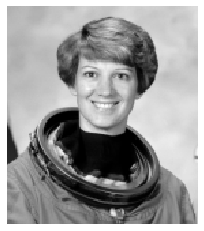

In [17]:
test_image = data.astronaut()
test_image = rgb2gray(test_image)
#test_image = cv2.resize(test_image, (96,96))
test_image = transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off')
indices, patches = zip(*sliding_window(test_image, patch_size=positive_patches[0].shape))
patches_hog = np.array([get_hog_features(patch) for patch in patches])
patches_hog.shape

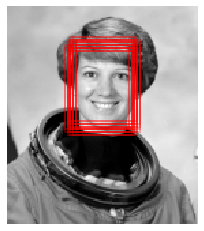

In [20]:
labels = model.predict(patches_hog)
labels.sum()

fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

(-0.5, 299.5, 199.5, -0.5)

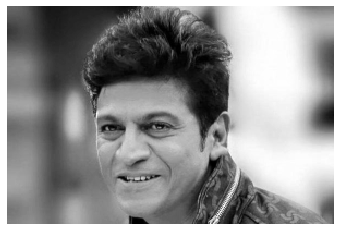

In [52]:
test_image2 = io.imread('image.png')
#test_image2 = data.astronaut()
test_image2 = rgb2gray(test_image2)
#test_image = cv2.resize(test_image, (96,96))
test_image2 = transform.rescale(test_image2, 0.5)
#test_image2 = test_image2[:160, 40:180]
plt.imshow(test_image2, cmap='gray')
plt.axis('off')

In [53]:
indices, patches = zip(*sliding_window(test_image2, patch_size=positive_patches[0].shape, scale=0.75))
patches_hog = np.array([get_hog_features(patch) for patch in patches])
patches_hog.shape

(416, 1260)

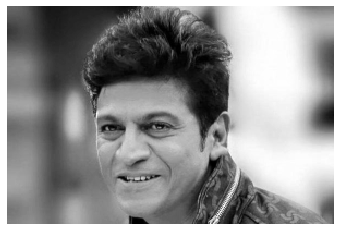

In [54]:
labels = model.predict(patches_hog)
labels.sum()

fig, ax = plt.subplots()
ax.imshow(test_image2, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

In [46]:
test_image2.shape

(200, 300)